In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sayantikalaskar","key":"9c46cbc3dc0f3d53e9eef348359a288e"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d iamsouravbanerjee/animal-image-dataset-90-different-animals

Dataset URL: https://www.kaggle.com/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals
License(s): other
 99% 649M/656M [00:12<00:00, 51.5MB/s]
100% 656M/656M [00:12<00:00, 53.3MB/s]


In [5]:
!unzip animal-image-dataset-90-different-animals.zip

Streaming output truncated to the last 5000 lines.
  inflating: animals/animals/bison/73b10839bc.jpg  
  inflating: animals/animals/bison/74dc1dd32a.jpg  
  inflating: animals/animals/bison/75ab166a7d.jpg  
  inflating: animals/animals/bison/79e1610d01.jpg  
  inflating: animals/animals/bison/7ba5eee91f.jpg  
  inflating: animals/animals/bison/7d214aab4b.jpg  
  inflating: animals/animals/bison/7f2ef9ab03.jpg  
  inflating: animals/animals/bison/82ec723a4f.jpg  
  inflating: animals/animals/bison/85e145af6c.jpg  
  inflating: animals/animals/bison/862e2c6379.jpg  
  inflating: animals/animals/bison/87a5c700ad.jpg  
  inflating: animals/animals/bison/88b723ce90.jpg  
  inflating: animals/animals/bison/8c3af742c3.jpg  
  inflating: animals/animals/bison/8e34044b98.jpg  
  inflating: animals/animals/bison/8e6adbdc40.jpg  
  inflating: animals/animals/bison/8fce80d5ba.jpg  
  inflating: animals/animals/bison/961a895686.jpg  
  inflating: animals/animals/bison/984a5b583d.jpg  
  inflating: 

In [6]:
#Importing libraries
import cv2
import glob
import os
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score , confusion_matrix
from sklearn import preprocessing

#tensorflow libraries
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Model, Sequential
from keras.layers import Dense, Dropout , BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

Creating a Dataframe using dataset

In [9]:
path = "/content/animals/animals"

data = {"imgpath": [] , "labels": [] }

category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imgpath"].append(fpath)
        data["labels"].append(folder)


df = pd.DataFrame(data)

Spliting Dataset into Train & Test

In [10]:
train_df, Temp_df = train_test_split(df,  train_size= 0.70 , shuffle=True, random_state=124)
valid_df , test_df = train_test_split(Temp_df ,  train_size= 0.70 , shuffle=True, random_state=124)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

#Removing old index columns
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

#Displaying train dataframe
print(train_df[["imgpath", "labels"]].head())

#Checking the shape of dataframe
print(train_df.shape)

                                           imgpath   labels
0   /content/animals/animals/possum/7ed931fc96.jpg   possum
1  /content/animals/animals/gorilla/36ba2541c2.jpg  gorilla
2  /content/animals/animals/hamster/8b8af1610a.jpg  hamster
3   /content/animals/animals/oyster/ecfebda8d5.jpg   oyster
4  /content/animals/animals/raccoon/9c563eb175.jpg  raccoon
(3779, 2)


Checking Image Data

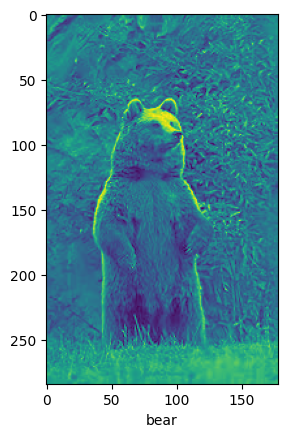

In [11]:
filepath = "/content/animals/animals/bear"

for img_path in os.listdir(filepath):
    img = cv2.imread(os.path.join(filepath, img_path), 0)
    plt.imshow(img)
    plt.xlabel(filepath.split("/")[-1])
    plt.show()
    break

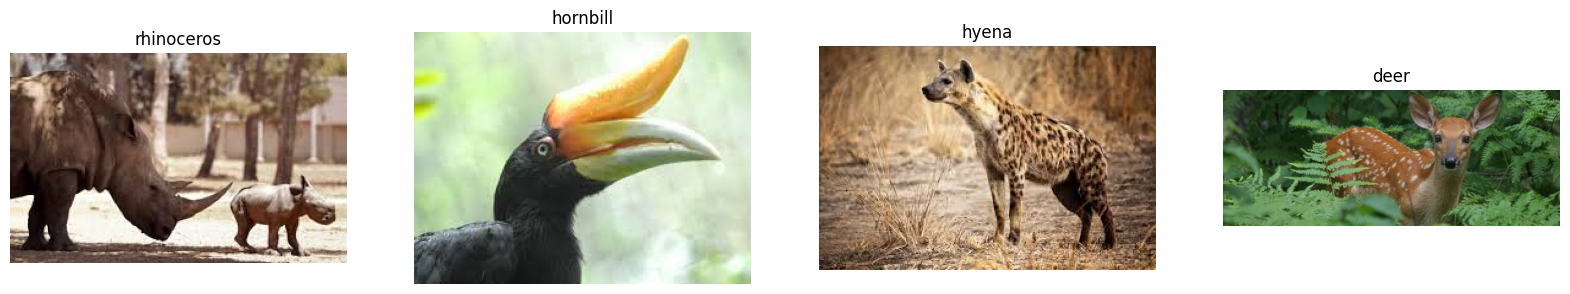

In [12]:
#Defining size of displayed image
plt.figure(figsize=(20,20))

#Displaying images from test dataframe
for i, row in test_df.sample(n=4).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

Defining augmentation and dataloaders

In [13]:
BATCH_SIZE = 16
IMAGE_SIZE = (224, 224)

generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=20,
    shear_range=0.2,
    validation_split=0.2
)

# Split the data into three categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_images = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 3779 validated image filenames belonging to 90 classes.
Found 1134 validated image filenames belonging to 90 classes.
Found 487 validated image filenames belonging to 90 classes.


VGG Model

In [14]:
# Load the pretained model
pretrained_model = tf.keras.applications.VGG16(
    input_shape=(224, 224, 3),
    include_top=False, # we don`t need a pre-trained top layer (output layer)
    weights='imagenet',
    pooling='max'
)


# Freezing the layers of a pretrained neural network
for i, layer in enumerate(pretrained_model.layers):
    pretrained_model.layers[i].trainable = False

58889256/58889256 [==============================] - 1s 0us/step


In [15]:
num_classes = len(set(train_images.classes))


# Data Augmentation Step
sequence = tf.keras.Sequential()


inputs = layers.Input(shape = (224,224,3), name='inputLayer')
x = sequence(inputs)
pretrain_out = pretrained_model(x, training = False)
x = layers.Dense(256)(pretrain_out)
x = layers.Activation(activation="relu")(x)
x = BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(num_classes)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x) # mixed_precision need separated Dense and Activation layers
model = Model(inputs=inputs, outputs=outputs)


model.compile(
    optimizer=tf.keras.optimizers.Adam(0.00005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# model.load_weights('./checkpoints/my_checkpoint')
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     multiple                  0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                             

In [16]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=10,
)
model.save_weights('./checkpoints/my_checkpoint')

Epoch 1/10
237/237 [==============================] - 126s 490ms/step - loss: 5.1055 - accuracy: 0.0188 - val_loss: 4.9270 - val_accuracy: 0.0282
Epoch 2/10
237/237 [==============================] - 98s 413ms/step - loss: 4.6310 - accuracy: 0.0431 - val_loss: 4.4216 - val_accuracy: 0.0582
Epoch 3/10
237/237 [==============================] - 103s 433ms/step - loss: 4.2497 - accuracy: 0.0762 - val_loss: 4.1063 - val_accuracy: 0.1005
Epoch 4/10
237/237 [==============================] - 89s 374ms/step - loss: 3.9006 - accuracy: 0.1146 - val_loss: 3.7930 - val_accuracy: 0.1473
Epoch 5/10
237/237 [==============================] - 86s 362ms/step - loss: 3.6175 - accuracy: 0.1694 - val_loss: 3.5359 - val_accuracy: 0.1887
Epoch 6/10
237/237 [==============================] - 88s 372ms/step - loss: 3.3777 - accuracy: 0.2125 - val_loss: 3.3295 - val_accuracy: 0.2187
Epoch 7/10
237/237 [==============================] - 86s 362ms/step - loss: 3.1472 - accuracy: 0.2596 - val_loss: 3.1618 - val_

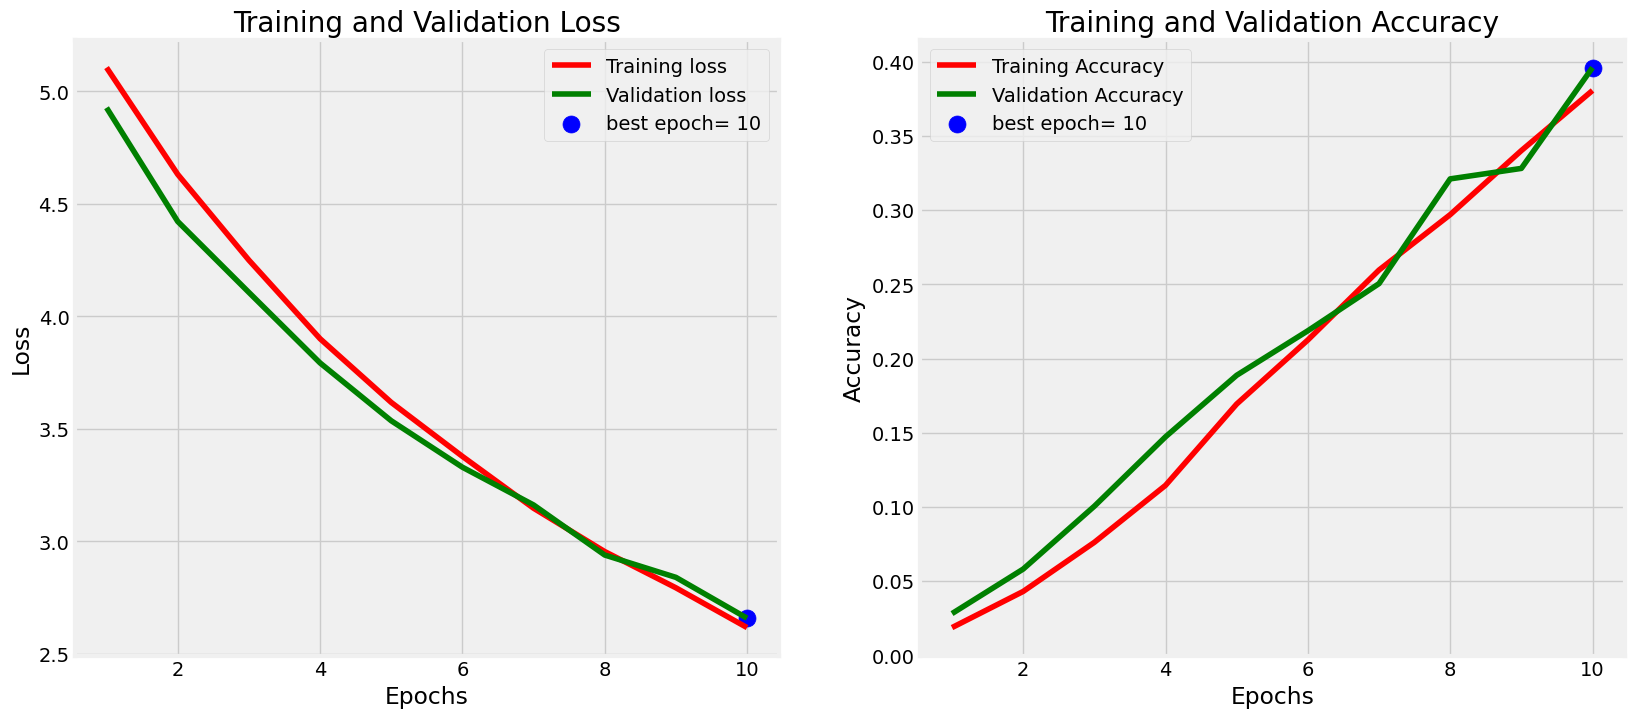

In [17]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [18]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 2.56973
Test Accuracy: 38.81%


In [19]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 2.57165
Test Accuracy: 40.45%


ResNET

In [20]:
# Load the pretained model
pretrained_resnet = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False, # we don`t need a pre-trained top layer (output layer)
    weights='imagenet',
    pooling='max'
)


# Freezing the layers of a pretrained neural network
for i, layer in enumerate(pretrained_resnet.layers):
    pretrained_resnet.layers[i].trainable = False

94765736/94765736 [==============================] - 0s 0us/step


In [21]:
num_classes = len(set(train_images.classes))


sequence = tf.keras.Sequential()
inputs = layers.Input(shape = (224,224,3), name='inputLayer')
x = sequence(inputs)
pretrain_out = pretrained_resnet(x, training = False)
x = layers.Dense(256)(pretrain_out)
x = layers.Activation(activation="relu")(x)
x = BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(num_classes)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x) # mixed_precision need separated Dense and Activation layers
model_resnet = Model(inputs=inputs, outputs=outputs)


model_resnet.compile(
    optimizer=tf.keras.optimizers.Adam(0.00005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# model.load_weights('./checkpoints/my_checkpoint')
print(model_resnet.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   multiple                  0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                           

In [22]:
history_resnet = model_resnet.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=10,
)
model_resnet.save_weights('./checkpoints/my_checkpoint2')

Epoch 1/10
237/237 [==============================] - 94s 372ms/step - loss: 5.2847 - accuracy: 0.0280 - val_loss: 4.3539 - val_accuracy: 0.0653
Epoch 2/10
237/237 [==============================] - 106s 449ms/step - loss: 4.4067 - accuracy: 0.0654 - val_loss: 3.6892 - val_accuracy: 0.1517
Epoch 3/10
237/237 [==============================] - 85s 357ms/step - loss: 3.8308 - accuracy: 0.1408 - val_loss: 3.2113 - val_accuracy: 0.2663
Epoch 4/10
237/237 [==============================] - 85s 357ms/step - loss: 3.3626 - accuracy: 0.2093 - val_loss: 2.8805 - val_accuracy: 0.3351
Epoch 5/10
237/237 [==============================] - 86s 363ms/step - loss: 3.0138 - accuracy: 0.2831 - val_loss: 2.5864 - val_accuracy: 0.4153
Epoch 6/10
237/237 [==============================] - 85s 359ms/step - loss: 2.7390 - accuracy: 0.3350 - val_loss: 2.3764 - val_accuracy: 0.4718
Epoch 7/10
237/237 [==============================] - 86s 362ms/step - loss: 2.4761 - accuracy: 0.4022 - val_loss: 2.1368 - val_a

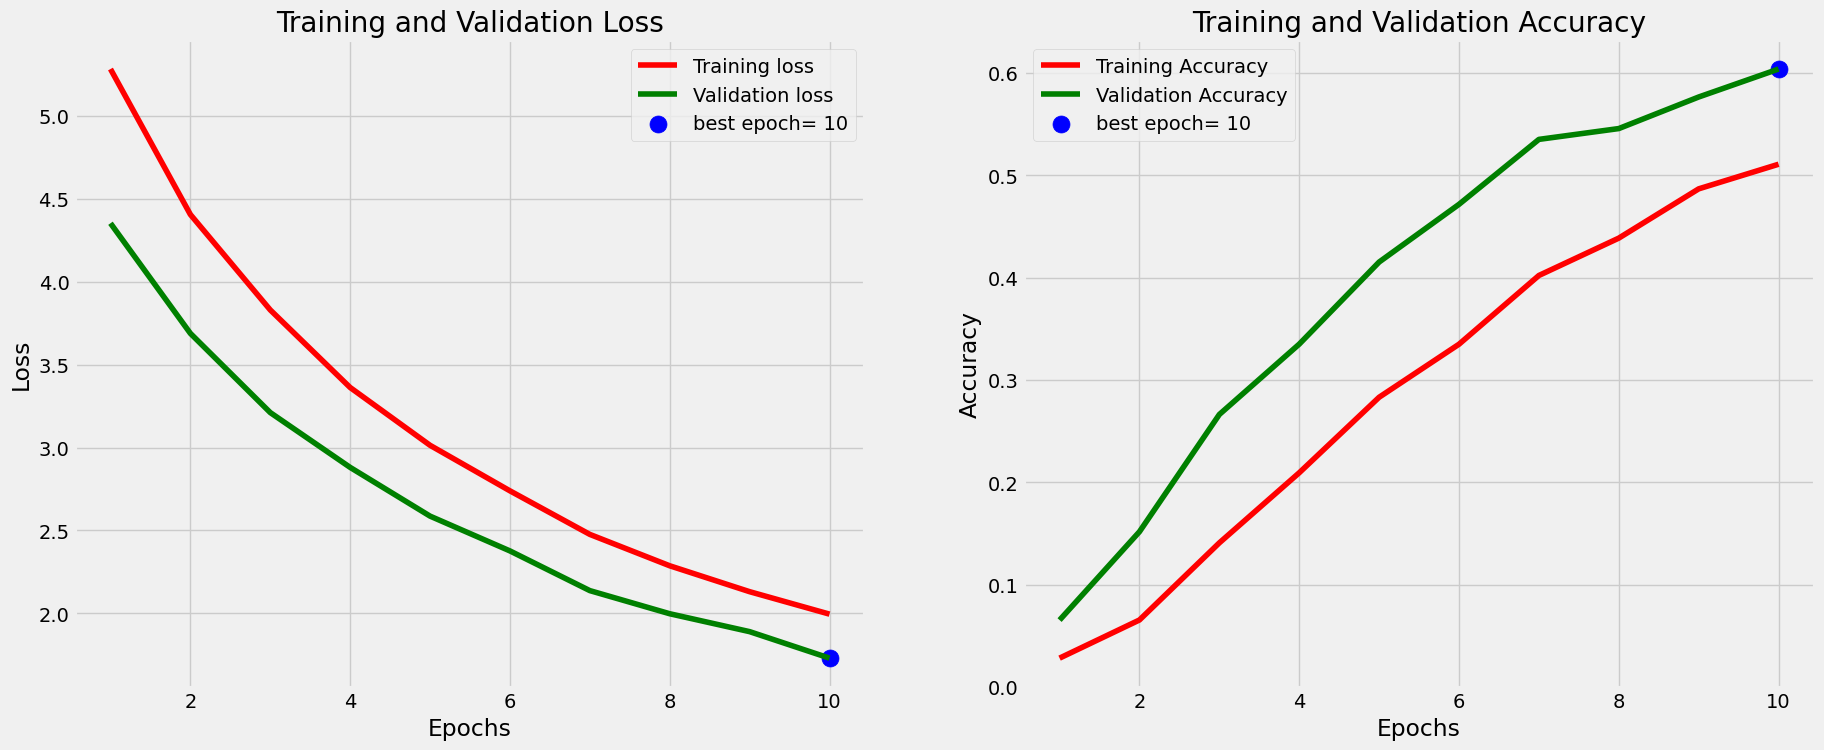

In [23]:
tr_acc = history_resnet.history['accuracy']
tr_loss = history_resnet.history['loss']
val_acc = history_resnet.history['val_accuracy']
val_loss = history_resnet.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [24]:
results = model_resnet.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 1.64145
Test Accuracy: 62.22%


In [25]:
pretrained_resnet.trainable = True
for layer in pretrained_resnet.layers:
    if isinstance(layer, layers.BatchNormalization): # set BatchNorm layers as not trainable
        layer.trainable = False

# let`s see first 10 layers
for l in pretrained_resnet.layers[:10]:
    print(l.name, l.trainable)

model_resnet.compile(
    optimizer=tf.keras.optimizers.Adam(0.00001), # fine tuning requires very little learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# model.load_weights('./checkpoints/my_checkpoint')
print(model_resnet.summary())
history = model_resnet.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=15,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True), # if val loss decreases for 5 epochs in a row, stop training,
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)
model_resnet.save_weights('./checkpoints/my_checkpoint3')

input_2 True
conv1_pad True
conv1_conv True
conv1_bn False
conv1_relu True
pool1_pad True
pool1_pool True
conv2_block1_1_conv True
conv2_block1_1_bn False
conv2_block1_1_relu True
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   multiple                  0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 batch_norm

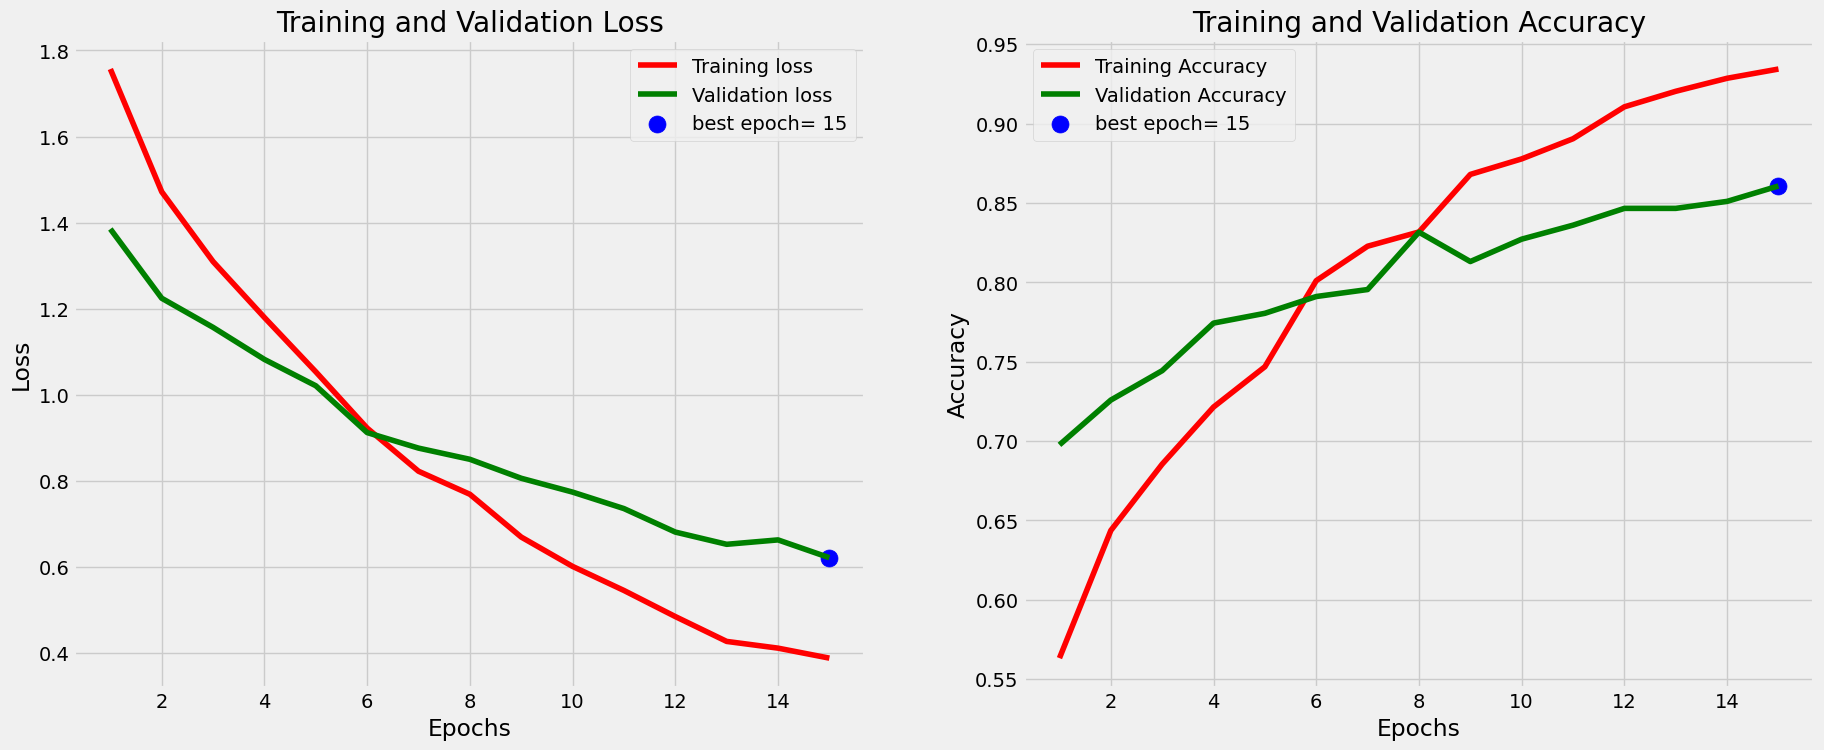

In [26]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [27]:
results = model_resnet.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.59522
Test Accuracy: 84.80%


In [28]:
y_true = test_images.classes
y_pred = np.argmax(model_resnet.predict(test_images), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images.class_indices.keys()))

31/31 [==============================] - 9s 253ms/step
F1 Score: 0.8416590156966833
                precision    recall  f1-score   support

      antelope       0.40      0.50      0.44         4
        badger       1.00      0.86      0.92         7
           bat       0.33      1.00      0.50         1
          bear       1.00      1.00      1.00         8
           bee       1.00      1.00      1.00         2
        beetle       0.75      1.00      0.86         3
         bison       1.00      0.78      0.88         9
          boar       0.80      0.80      0.80         5
     butterfly       1.00      0.50      0.67         4
           cat       1.00      1.00      1.00         7
   caterpillar       0.60      1.00      0.75         3
    chimpanzee       1.00      0.71      0.83         7
     cockroach       1.00      0.83      0.91         6
           cow       0.75      0.75      0.75         8
        coyote       0.83      0.83      0.83         6
          crab     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
classes = dict(zip(test_images.class_indices.values(), test_images.class_indices.keys()))
Predictions = pd.DataFrame({"Image Index" : list(range(len(test_images.labels))),
                            "Test Labels" : test_images.labels,
                            "Test Classes" : [classes[i] for i in test_images.labels],
                            "Prediction Labels" : y_pred,
                            "Prediction Classes" : [classes[i] for i in y_pred],
                            "Path": test_images.filenames,
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(model_resnet.predict(test_images), axis = 1))]
                           })
Predictions.head(8)

31/31 [==============================] - 8s 248ms/step


Image Index  Test Labels Test Classes  Prediction Labels  \
0            0           44     ladybugs                 10   
1            1           79     squirrel                 79   
2            2           42     kangaroo                 42   
3            3           43        koala                 43   
4            4           75        sheep                 75   
5            5           24     elephant                 24   
6            6           67      raccoon                 67   
7            7            5       beetle                  5   

  Prediction Classes                                              Path  \
0        caterpillar  /content/animals/animals/ladybugs/1d03119184.jpg   
1           squirrel  /content/animals/animals/squirrel/1c0f6fc48f.jpg   
2           kangaroo  /content/animals/animals/kangaroo/5ea64d24d6.jpg   
3              koala     /content/animals/animals/koala/53e6ef5129.jpg   
4              sheep     /content/animals/animals/sheep/5f6cb7b328.jpg   
5           elephant  /content/animals/animals/elephant/24dd5cb3a6.jpg   
6            raccoon   /content/animals/animals/raccoon/4c501b3006.jpg   
7             beetle    /content/animals/animals/beetle/29309ff01e.jpg   

   Prediction Probability  
0                0.274907  
1                0.485912  
2                0.400315  
3                0.981262  
4                0.965806  
5                0.913619  
6                0.975394  
7                0.585202

Correct Predictions

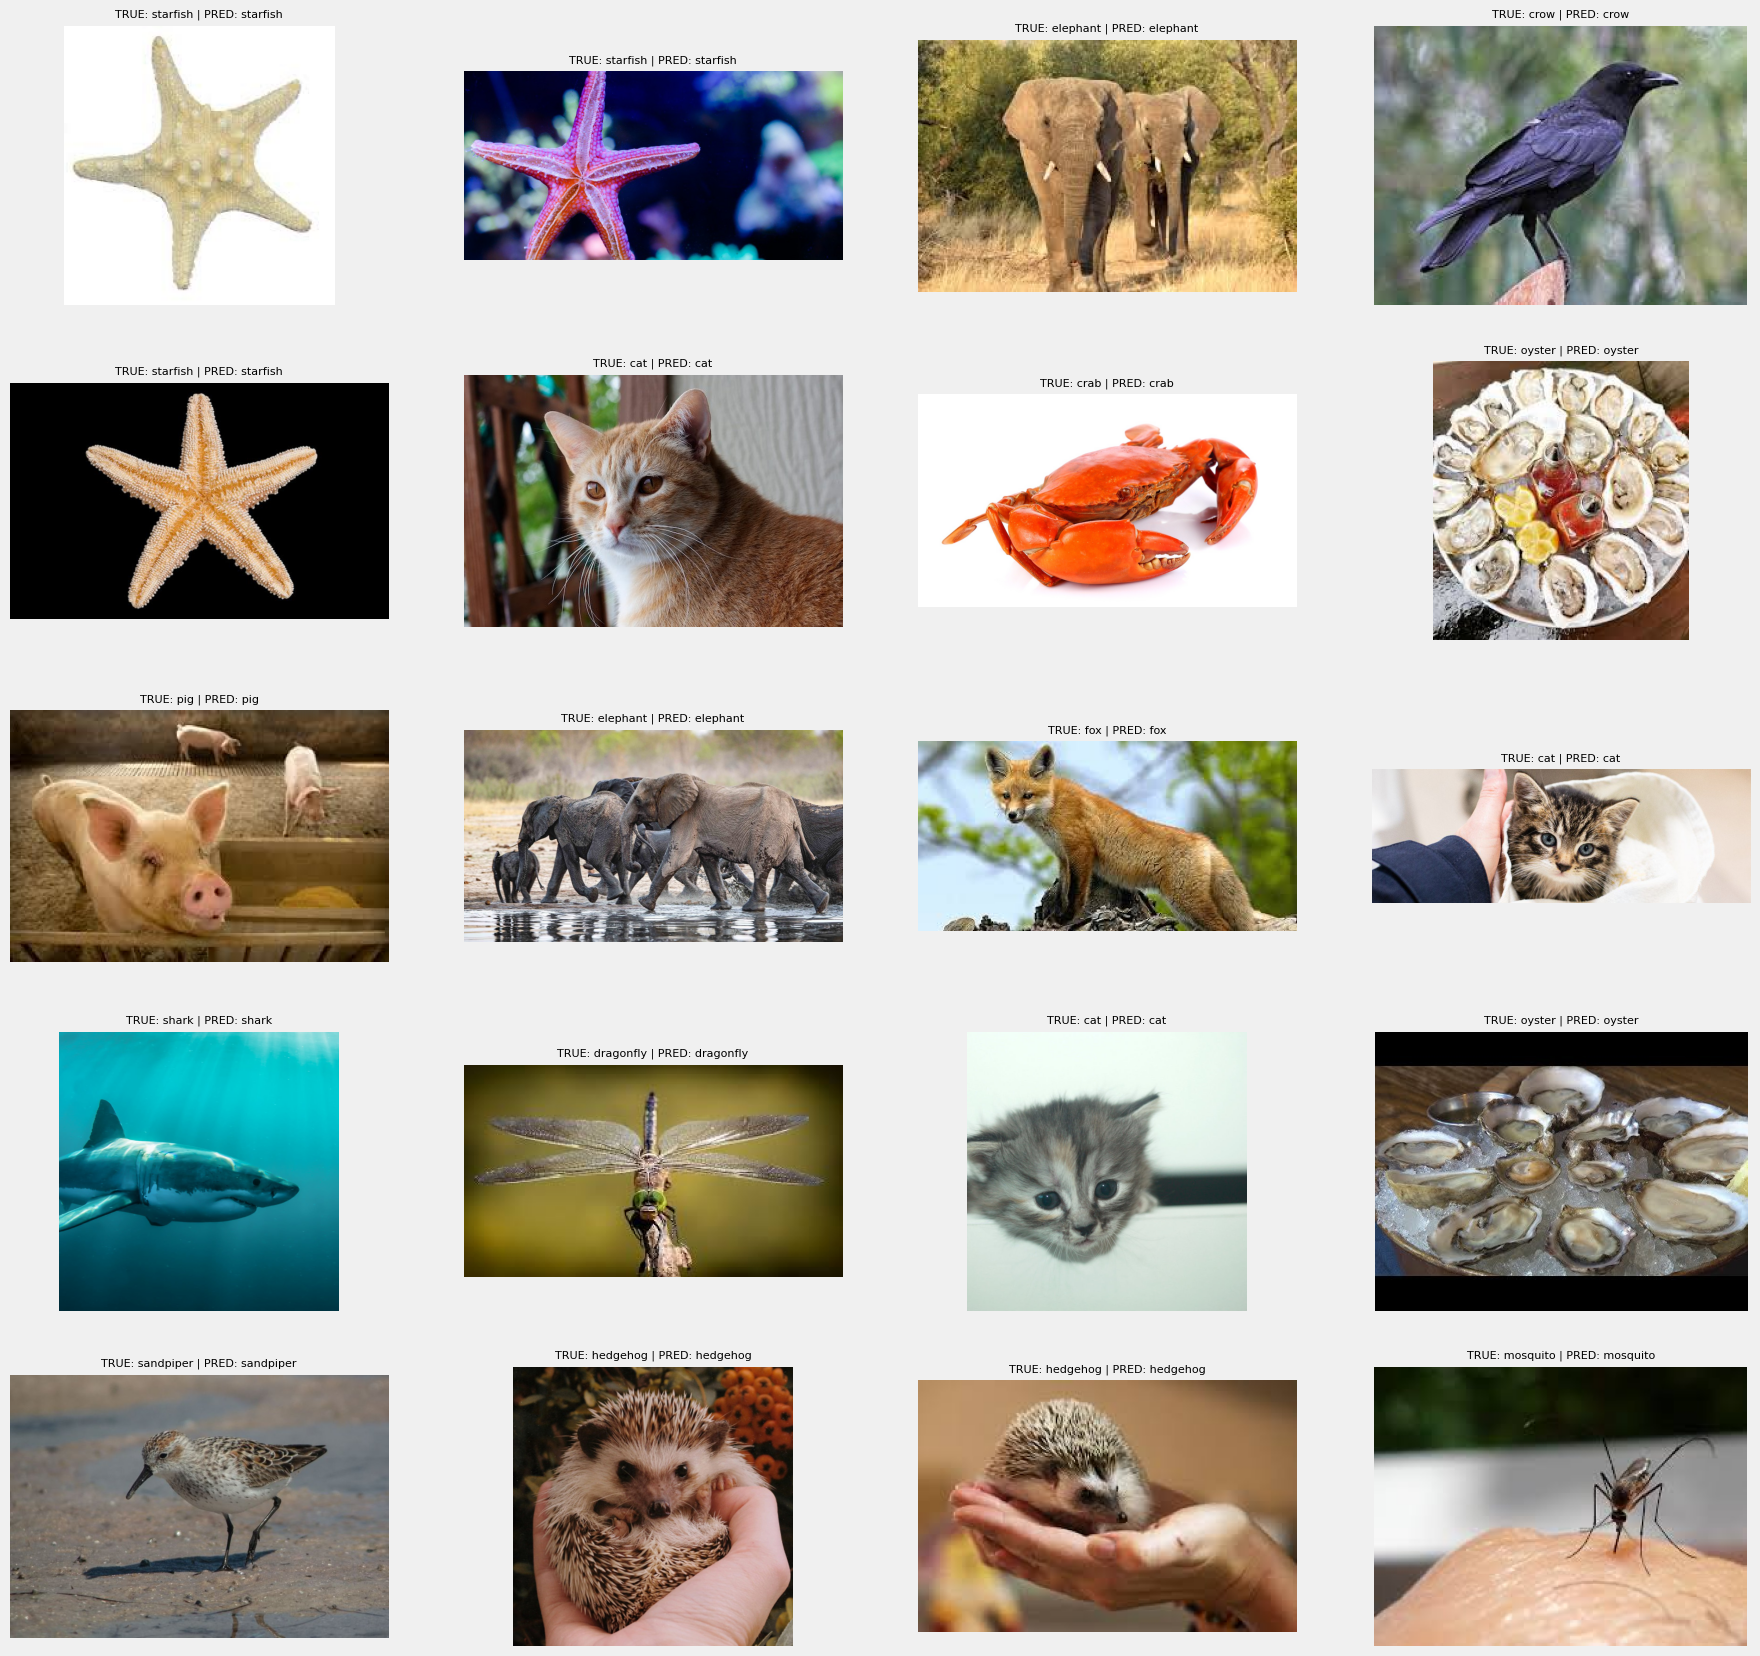

In [30]:
plt.figure(figsize=(20,20))
for i, row in Predictions[Predictions["Test Labels"] == Predictions["Prediction Labels"]].sort_values("Prediction Probability").tail(20).reset_index().iterrows():
    plt.subplot(5,4,i+1)
    image_path = row['Path']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'TRUE: {row["Test Classes"]} | PRED: {row["Prediction Classes"]}', fontsize=8)
    plt.axis('off')

plt.show()

Errors

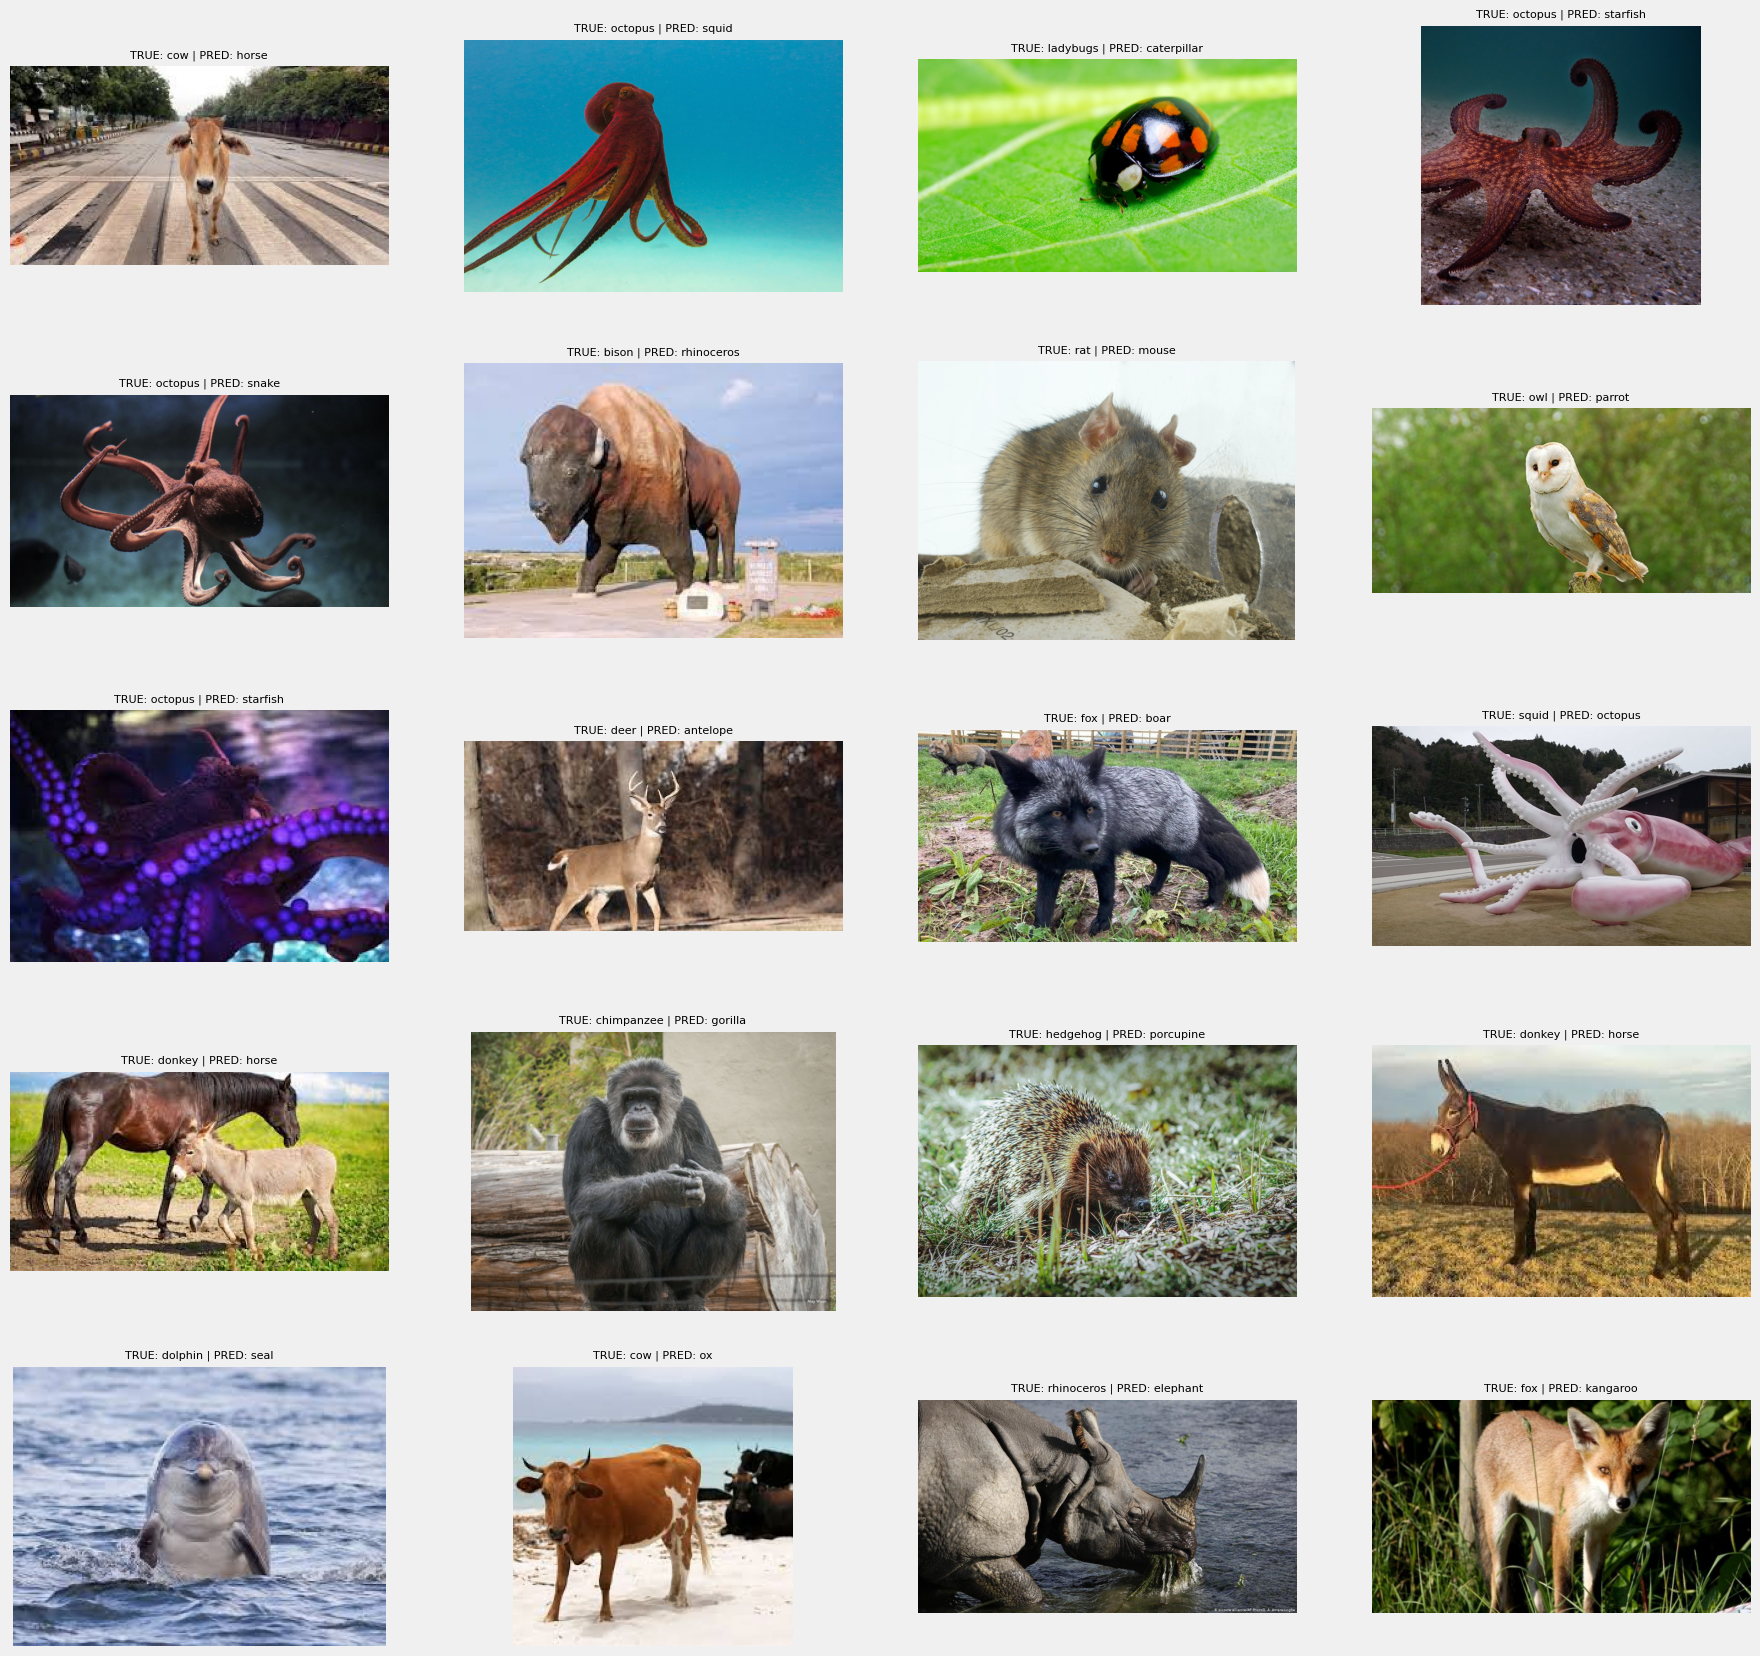

In [31]:
plt.figure(figsize=(20,20))
for i, row in Predictions[Predictions["Test Labels"] != Predictions["Prediction Labels"]].sort_values("Prediction Probability").tail(20).reset_index().iterrows():
    plt.subplot(5,4,i+1)
    image_path = row['Path']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'TRUE: {row["Test Classes"]} | PRED: {row["Prediction Classes"]}', fontsize=8)
    plt.axis('off')

plt.show()